# Graph Mining - Final Project

Authors:
- Filippo Casagrande
- Jorge Morgado
- Hamed Aezami

## Importing necessary packages

We will use mainly:
- `networkx` for graph manipulation
- `sklearn` for classification metrics estimation
- `matplotlib` for plotting the results

In [2]:
import networkx as nx
import numpy as np

from pathlib import Path
from itertools import combinations

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

import matplotlib.pyplot as plt

SEED = 42

## Loading the data

We define utility functions that will help us to load and parse the graphs

In [3]:
def load_graph_from_txt(file_path: str) -> list[nx.Graph]:
    graphs = [None for _ in range(8)]
    data = np.loadtxt(file_path, skiprows=1, dtype=float)
    data = data[:, -1]
    for i in range(8):
        start_idx = i * 10000
        end_idx = (i + 1) * 10000
        adj_matrix = data[start_idx : end_idx].reshape(100, 100)
        for j in range(100):
            adj_matrix[j, j] = 0
        graphs[i] = nx.from_numpy_array(adj_matrix)
    return graphs


def load_graphs(folder: Path) -> list[list[nx.Graph]]:
    graphs = [None] * 248
    for file in folder.iterdir():
        print(f"Loading {file}", end="\r")
        idx = int(file.stem.split("_")[0]) - 1
        graphs[idx] = load_graph_from_txt(file)
    assert all(graph is not None for graph in graphs)
    return graphs

Then, we load all the graphs from each experiment set and label them accordingly

In [4]:
m_graphs = load_graphs(Path("./brain_networks/movie"))
s_graphs = load_graphs(Path("./brain_networks/story"))

In [5]:
for graphs in m_graphs:
    for G in graphs:
        G.graph["label"] = "movie"

for graphs in s_graphs:
    for G in graphs:
        G.graph["label"] = "story"

graphs = m_graphs + s_graphs

## Splitting the data

The next function will be used to split the dataset (similar to the `train_test_split` function from sklearn)

In [6]:
def train_test_split(
    graphs: list[list[nx.Graph]], train_size: float = 0.8, seed=None
) -> tuple[list[nx.Graph], list[str], list[nx.Graph], list[str]]:
    if seed is not None:
        np.random.seed(seed)
    np.random.shuffle(graphs)
    train_idx = int(len(graphs) * train_size)
    return (
        graphs[:train_idx],
        [t_graphs[0].graph["label"] for t_graphs in graphs[:train_idx]],
        graphs[train_idx:],
        [t_graphs[0].graph["label"] for t_graphs in graphs[train_idx:]],
    )

Next, we split the dataset in train and test subsets

In [7]:
X_train, y_train, X_test, y_test = train_test_split(graphs, seed=SEED)

In [8]:
def split_by_label(graphs: list[list[nx.Graph]]) -> tuple[list[list[nx.Graph]], list[list[nx.Graph]]]:
    movie, story = [], []
    for t_graphs in graphs:
        if t_graphs[0].graph["label"] == "movie":
            movie.append(t_graphs)
        else:
            story.append(t_graphs)
    return movie, story

def get_graphs_at_time(graphs: list[list[nx.Graph]], time: int) -> list[nx.Graph]:
    return [t_graphs[time] for t_graphs in graphs]

---

In [24]:
def abs_graph(G: nx.Graph) -> nx.Graph:
    new_graph = G.copy()
    for _, _, d in new_graph.edges(data=True):
        d["weight"] = abs(d["weight"])
    return new_graph


def inverse_graph(G: nx.Graph, inplace: bool = False) -> nx.Graph:
    if not inplace:
        G = G.copy()
    for _, _, d in G.edges(data=True):
        d["weight"] = 1 - d["weight"]
    return G


def threshold_graph(
    G: nx.Graph,
    threshold: float,
    inplace: bool = False,
    replace_val: None | float | int = None,
) -> nx.Graph:
    if not inplace:
        G = G.copy()

    edges_to_remove = []
    for u, v, d in G.edges(data=True):
        new_val = d["weight"] if replace_val is None else replace_val
        d["weight"] = new_val if d["weight"] >= threshold else 0
        if d["weight"] == 0:
            edges_to_remove.append((u, v))

    G.remove_edges_from(edges_to_remove)
    return G

In [63]:
def plot_metric(m_values, s_values, metric_name, title: str, show: bool = True):
    m_avg = np.mean(m_values, axis=0)
    s_avg = np.mean(s_values, axis=0)

    m_std = np.std(m_values, axis=0)
    s_std = np.std(s_values, axis=0)

    plt.plot(m_avg, label="Movie")
    plt.fill_between(range(len(m_avg)), m_avg - m_std, m_avg + m_std, alpha=0.3)

    plt.plot(s_avg, label="Story")
    plt.fill_between(range(len(s_avg)), s_avg - s_std, s_avg + s_std, alpha=0.3)

    plt.xlabel("Time")
    plt.ylabel(metric_name)
    plt.title(title)
    plt.legend()

    if show:
        plt.show()

In [47]:
THRESHOLDS = [0.0, 0.2, 0.4, 0.6, 0.8]

movie_graphs, story_graphs = split_by_label(X_train)

In [61]:
def estimate_metric(movie_graphs, story_graphs, metrix_estimator, *args, **kwargs):
    m_values = np.zeros((len(movie_graphs), 8))
    s_values = np.zeros((len(story_graphs), 8))

    for i, experiment in enumerate(movie_graphs):
        for j, G in enumerate(experiment):
            print(f"Processing movie experiment {i + 1}/{len(movie_graphs)}", end="\r")
            m_values[i, j] = metrix_estimator(G, *args, **kwargs)

    for i, experiment in enumerate(story_graphs):
        for j, G in enumerate(experiment):
            print(f"Processing story experiment {i + 1}/{len(movie_graphs)}", end="\r")
            s_values[i, j] = metrix_estimator(G, *args, **kwargs)

    return m_values, s_values

In [54]:
def diameter_values(movie_graphs, story_graphs, threshold: float = 0.2):
    def estimator(G, threshold):
        G = inverse_graph(
            threshold_graph(abs_graph(G), threshold, inplace=True), inplace=True
        )
        return nx.diameter(G, weight="weight")

    return estimate_metric(movie_graphs, story_graphs, estimator, threshold)

def analyse_diameter(movie_graphs, story_graphs, thresholds=THRESHOLDS):
    for i, threshold in enumerate(thresholds):
        m_values, s_values = diameter_values(movie_graphs, story_graphs, threshold)
        plt.subplot(len(thresholds), 1, i + 1)
        plot_metric(m_values, s_values, "Diameter", show=False)
    plt.show()

In [64]:
def connected_components_values(movie_graphs, story_graphs, threshold: float = 0.8):
    def estimator(G, threshold):
        G = inverse_graph(
            threshold_graph(abs_graph(G), threshold, inplace=True), inplace=True
        )
        return nx.number_connected_components(G)

    return estimate_metric(movie_graphs, story_graphs, estimator, threshold)

def connected_components_analysis(movie_graphs, story_graphs, thresholds=THRESHOLDS):
    for i, threshold in enumerate(thresholds):
        m_values, s_values = connected_components_values(movie_graphs, story_graphs, threshold)
        plt.subplot(len(thresholds), 1, i + 1)
        plot_metric(m_values, s_values, "Connected Components", "connected components", show=False)
    plt.show()

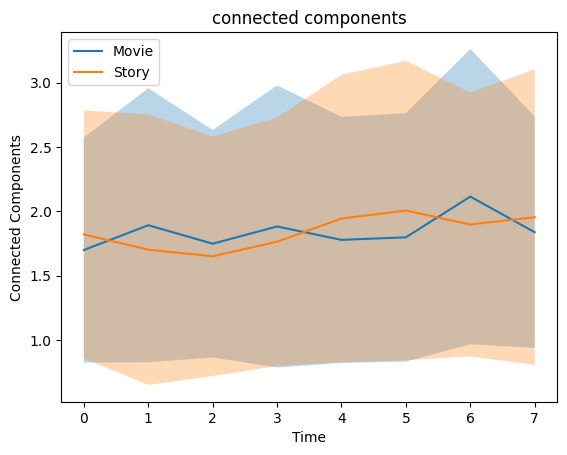

In [65]:
connected_components_analysis(movie_graphs, story_graphs, thresholds=[0.8])

Failed to compute diameter for 9 graphs


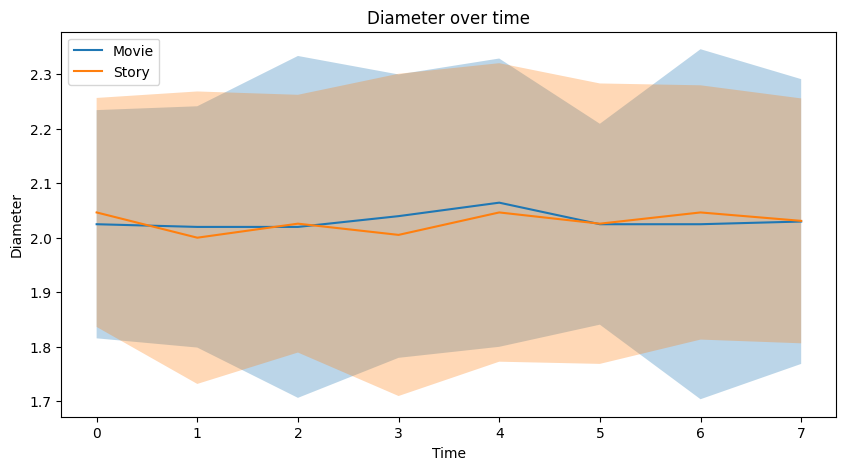

In [44]:
m_values, s_values = diameter_values(movie_graphs, story_graphs, .4)
plot_metric(m_values, s_values, "Diameter")

Failed to compute diameter for 1653 graphs


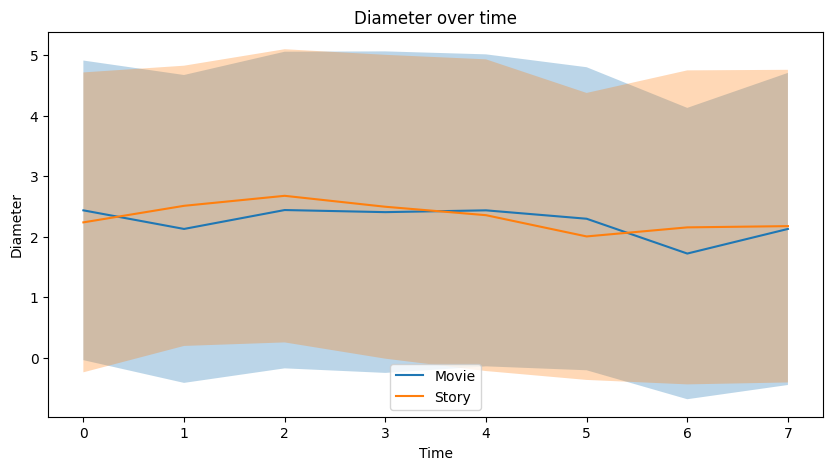

In [45]:
m_values, s_values = diameter_values(movie_graphs, story_graphs, .8)
plot_metric(m_values, s_values, "Diameter")